In [1]:
import pandas as pd

df = pd.read_csv("../Alarm_Data_DIR/PVCI-merged/All_Merged.csv")
df

,Event Time,Location Tag,Source,Condition,Action,Priority,Description,Value,Units
0,2025-01-01 00:00:00,SERVER_PVC,DAILY RP,PERIODIC,NaN,J 00,Report Periodic Request,12,NaN
1,2025-01-01 00:00:03,1600,PI1601,PVLOLO,NaN,J 00,HE1601 OUTLET,0.239591,kg/cm2G
2,2025-01-01 00:00:04,1500,TI1507,PVLOW,ACK,NaN,TW1501 BOTTOM,NaN,NaN
3,2025-01-01 00:00:05,IOLINK04_1,AIOR-704,OP Fail in circuit/field wire,OK,H 15,NaN,Channel_18_B,NaN
4,2025-01-01 00:00:07,1200,TIC1203,PVHIHI,NaN,H 00,HE1203 D/S TEMP,88.7875,C
...,...,...,...,...,...,...,...,...,...
903349,2025-03-17 10:55:00,1300,AI1301,PVLOW,NaN,L 00,VE1306 INLET,5.99933,ph
903350,2025-03-17 10:55:00,1300,AI1301,PVLOW,ACK,NaN,VE1306 INLET,NaN,NaN
903351,2025-03-17 10:55:00,SERVER_PVC,NaN,Demand,NaN,NaN,CSV export in progress...,NaN,NaN
903352,2025-03-17 10:56:00,SERVER_PVC,NaN,Demand,NaN,NaN,CSV export in progress...,NaN,NaN


# Update Calculations for Daily Alarms KPI Calculations

In [2]:
import pandas as pd

def calculate_alarm_frequency_metrics(df, iso_threshold=288, unacceptable_threshold=720):
    """
    ISO/EEMUA 191-compliant alarm frequency metrics.
    
    Calculates:
      • Unique alarm activations (Blank → ACK/OK)
      • Average alarms per day / hour / 10 minutes
      • % days > 288 (overloaded)
      • % days ≥ 720 (unacceptable)
      • Lists of those days and counts

    Parameters:
        df : DataFrame with columns ['Source', 'Action', 'Event Time']
        iso_threshold : int, default 288 alarms/day (ISO 18.2 reference)
        unacceptable_threshold : int, default 720 alarms/day (critical overload)
    """
    # ---------- Step 1: Clean ----------
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].fillna("").str.upper().str.strip()
    df = df.sort_values(["Source", "Event Time"]).reset_index(drop=True)

    # ---------- Step 2: Identify Unique Alarms ----------
    activations = []
    for src, group in df.groupby("Source"):
        state = "IDLE"
        for _, row in group.iterrows():
            action = row["Action"]
            t = row["Event Time"]

            # New alarm trigger
            if action == "" and state in ["IDLE", "ACKED"]:
                activations.append({"Source": src, "StartTime": t})
                state = "ACTIVE"

            # Acknowledged
            elif action == "ACK" and state == "ACTIVE":
                state = "ACKED"

            # Cleared (OK)
            elif action == "OK":
                # Handles Blank→OK and Blank→OK→ACK
                if state in ["ACTIVE", "ACKED"]:
                    state = "IDLE"
                else:
                    state = "IDLE"

    activations_df = pd.DataFrame(activations)
    if activations_df.empty:
        return {"message": "No valid alarm activations found."}

    # ---------- Step 3: Time-based Calculations ----------
    activations_df["Date"] = activations_df["StartTime"].dt.date
    alarms_per_day = activations_df.groupby("Date").size().reset_index(name="Alarm_Count")

    total_alarms = len(activations_df)
    total_days = (activations_df["StartTime"].max() - activations_df["StartTime"].min()).days + 1
    total_hours = (activations_df["StartTime"].max() - activations_df["StartTime"].min()).total_seconds() / 3600

    avg_per_day = total_alarms / total_days if total_days > 0 else 0
    avg_per_hour = total_alarms / total_hours if total_hours > 0 else 0
    avg_per_10min = total_alarms / (total_hours * 6) if total_hours > 0 else 0

    # ---------- Step 4: ISO KPI Analysis ----------
    days_over_iso = alarms_per_day[alarms_per_day["Alarm_Count"] > iso_threshold]
    days_unacceptable = alarms_per_day[alarms_per_day["Alarm_Count"] >= unacceptable_threshold]

    percent_days_over_iso = (len(days_over_iso) / len(alarms_per_day)) * 100
    percent_days_unacceptable = (len(days_unacceptable) / len(alarms_per_day)) * 100

    # ---------- Step 5: Return Structured Results ----------
    summary = {
        "Average_Alarms_per_Day": round(avg_per_day, 2),
        "Average_Alarms_per_Hour": round(avg_per_hour, 2),
        "Average_Alarms_per_10min": round(avg_per_10min, 2),
        "Days_Over_288_Count": len(days_over_iso),
        "Days_Over_288_%": round(percent_days_over_iso, 2),
        "Days_Unacceptable_Count": len(days_unacceptable),
        "Days_Unacceptable_%": round(percent_days_unacceptable, 2),
        "Total_Days_Analyzed": len(alarms_per_day),
        "Total_Unique_Alarms": total_alarms,
        "Start_Date": activations_df["StartTime"].min(),
        "End_Date": activations_df["StartTime"].max(),
    }

    return {
        "Summary": summary,
        "Alarms_Per_Day": alarms_per_day,
        "Days_Over_288": days_over_iso,
        "Days_Unacceptable": days_unacceptable,
    }


In [3]:
result = calculate_alarm_frequency_metrics(df)
print(result["Summary"])


{'Average_Alarms_per_Day': 1280.64, 'Average_Alarms_per_Hour': 53.75, 'Average_Alarms_per_10min': 8.96, 'Days_Over_288_Count': 74, 'Days_Over_288_%': 98.67, 'Days_Unacceptable_Count': 69, 'Days_Unacceptable_%': 92.0, 'Total_Days_Analyzed': 75, 'Total_Unique_Alarms': 97329, 'Start_Date': Timestamp('2025-01-01 00:00:00'), 'End_Date': Timestamp('2025-03-17 10:55:00')}


In [4]:
print(result["Days_Unacceptable"])

          Date  Alarm_Count
0   2025-01-01         1416
1   2025-01-02         1303
2   2025-01-03         1209
3   2025-01-04         1769
4   2025-01-05         1537
..         ...          ...
69  2025-03-12         1118
70  2025-03-13          954
71  2025-03-14         1516
72  2025-03-15         1527
73  2025-03-16         1326

[69 rows x 2 columns]


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_alarm_frequency_trends(metrics_result):
    """
    Generates ready-to-send chart data + matplotlib preview for:
      - Daily alarm trend
      - Threshold lines (288, 720)
      - Highlights overloaded/unacceptable days
    """

    alarms_per_day = metrics_result["Alarms_Per_Day"]
    iso_days = metrics_result["Days_Over_288"]["Date"].tolist()
    bad_days = metrics_result["Days_Unacceptable"]["Date"].tolist()

    x = alarms_per_day["Date"]
    y = alarms_per_day["Alarm_Count"]

    # ---- Structure data for frontend ----
    chart_data = {
        "x": [str(date) for date in x],
        "y": y.tolist(),
        "thresholds": {"ISO_288": 288, "Unacceptable_720": 720},
        "highlight_days": {
            "Over_288": [str(d) for d in iso_days],
            "Unacceptable": [str(d) for d in bad_days]
        }
    }

    # ---- Plot Preview (for testing) ----
    plt.figure(figsize=(14, 6))
    plt.plot(x, y, label="Daily Alarm Count", color="royalblue", linewidth=2)
    plt.axhline(288, color="orange", linestyle="--", label="ISO Threshold (288/day)")
    plt.axhline(720, color="red", linestyle="--", label="Unacceptable (720/day)")

    plt.scatter(alarms_per_day[alarms_per_day["Date"].isin(iso_days)]["Date"],
                alarms_per_day[alarms_per_day["Date"].isin(iso_days)]["Alarm_Count"],
                color="orange", label=">288 Alarms", s=50)

    plt.scatter(alarms_per_day[alarms_per_day["Date"].isin(bad_days)]["Date"],
                alarms_per_day[alarms_per_day["Date"].isin(bad_days)]["Alarm_Count"],
                color="red", label="≥720 Alarms", s=50)

    plt.title("📈 Daily Alarm Trend with ISO Thresholds", fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Number of Alarms")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return chart_data

C:\Users\hmaba\AppData\Local\Temp\ipykernel_10100\1438911159.py:48: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Cybergen\engro project\alarm_system_RND\evnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


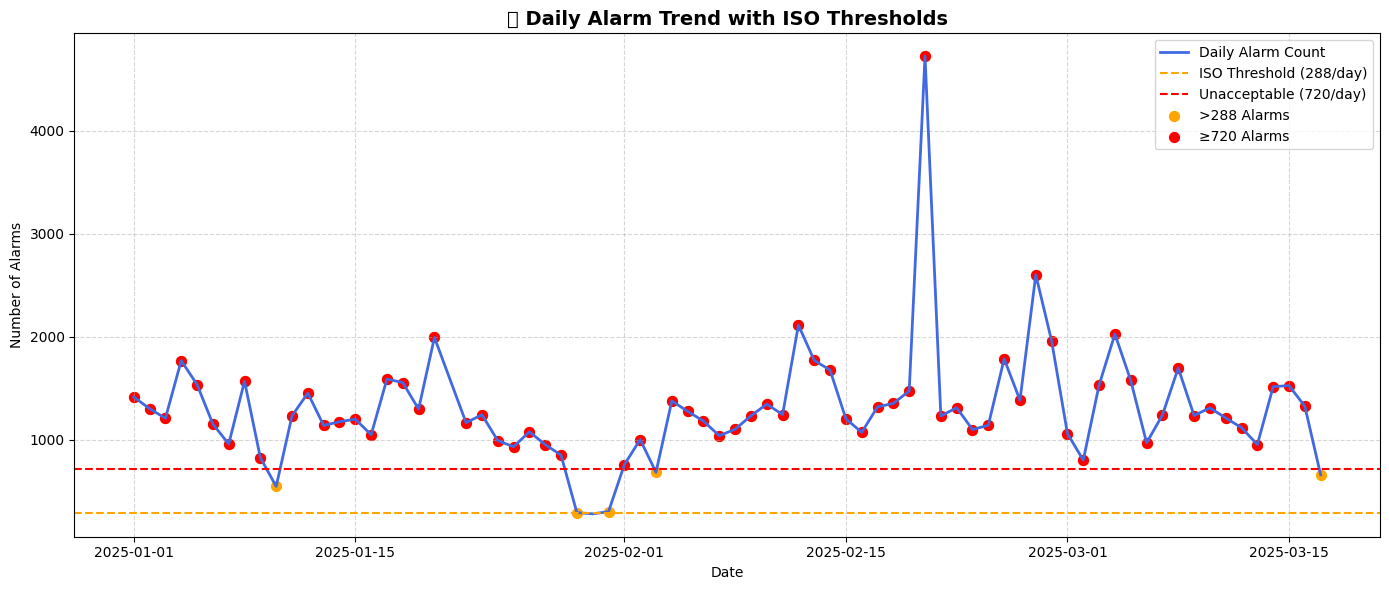

In [6]:
chart_data = plot_alarm_frequency_trends(result)

# Updated Calculation For Standing Alarms

In [8]:
import pandas as pd

# Threshold in minutes for a standing alarm to become stale
STALE_THRESHOLD_MIN = 3600

def analyze_basic_alarm_states(df):
    """
    ISO-style alarm state analysis
    Calculates:
      - Unique Alarms
      - Standing Alarms
      - Stale Alarms
      - Instrument Failures
    """
    # --- Clean and sort ---
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].fillna("").str.upper().str.strip()
    df["Condition"] = df["Condition"].fillna("").str.upper().str.strip()
    df = df.sort_values(["Source", "Event Time"])

    results = []

    for src, group in df.groupby("Source"):
        state = "IDLE"
        unique_count = 0
        standing_count = 0
        stale_count = 0
        instrument_failure_count = 0

        active_start = None
        active_condition = ""
        standing_flag = False  # becomes True when counted once

        for _, row in group.iterrows():
            action = row["Action"]
            t = row["Event Time"]
            cond = row["Condition"]

            # --- NEW ALARM ---
            if action == "" and state in ["IDLE", "ACKED"]:
                unique_count += 1
                state = "ACTIVE"
                active_start = t
                active_condition = cond
                standing_flag = False

            # --- ACK HANDLING ---
            elif action == "ACK" and state == "ACTIVE":
                state = "ACKED"

            # --- OK HANDLING ---
            elif action == "OK" and state in ["ACTIVE", "ACKED"]:
                state = "IDLE"
                active_start = None
                active_condition = ""
                standing_flag = False

            # --- STANDING ALARM CHECK ---
            if state == "ACTIVE" and active_start:
                duration_min = (t - active_start).total_seconds() / 60

                # Alarm becomes standing after threshold
                if duration_min >= STALE_THRESHOLD_MIN and not standing_flag:
                    standing_count += 1
                    standing_flag = True  # count only once

                    # Subtype classification
                    if any(k in active_condition for k in ["FAIL", "BAD"]):
                        instrument_failure_count += 1
                    else:
                        stale_count += 1

                # If duration keeps increasing, do NOT increment again
                # until cleared with OK (handled above)

        results.append({
            "Source": src,
            "Unique_Alarms": unique_count,
            "Standing_Alarms": standing_count,
            "Stale_Alarms": stale_count,
            "Instrument_Failure": instrument_failure_count
        })

    return pd.DataFrame(results)


In [9]:
standing_alarm_analyses = analyze_basic_alarm_states(df)

In [10]:
standing_alarm_analyses

,Source,Unique_Alarms,Standing_Alarms,Stale_Alarms,Instrument_Failure
0,$ACTIVITY_330413F2352AB609,1,1,1,0
1,AAH10023,1,0,0,0
2,AAH10026,2,0,0,0
3,AAH10027,22,0,0,0
4,AAH10028,1,0,0,0
...,...,...,...,...,...
1225,XSV8808,1,1,1,0
1226,XSV8811,1,0,0,0
1227,YI8800LP,6,0,0,0
1228,YI8802,21,0,0,0


# Updated Calculation For Chattering Alarms

In [11]:
import pandas as pd
from collections import deque

# thresholds
CHATTER_WINDOW_MIN = 10
CHATTER_MIN_COUNT = 3
INSTRUMENT_KEYWORDS = ["FAIL", "BAD"]

def detect_repeating_and_chattering(df):
    """
    Detect Repeating Alarms, Chattering Alarms, and Instrument Failures
    using the same verified unique alarm logic.
    """

    # --- Data Cleaning ---
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].fillna("").astype(str).str.upper().str.strip()
    df["Condition"] = df["Condition"].fillna("").astype(str).str.upper().str.strip()
    df = df.sort_values(["Source", "Event Time"])

    results = []

    # --- Per-Source Processing ---
    for src, group in df.groupby("Source"):
        state = "IDLE"  # IDLE, ACTIVE, ACKED
        alarm_times = []       # start times of alarms (Blank or ALARM)
        cond_texts = []        # conditions corresponding to each alarm

        for _, row in group.iterrows():
            action = row["Action"]
            t = row["Event Time"]
            cond = row["Condition"]

            # Follow the exact verified unique alarm logic
            if action == "":  # new alarm trigger
                if state in ["IDLE", "ACKED"]:
                    alarm_times.append(t)
                    cond_texts.append(cond)
                    state = "ACTIVE"

            elif action == "ACK" and state == "ACTIVE":
                state = "ACKED"

            elif action == "OK":
                state = "IDLE"

        unique_alarms = len(alarm_times)
        is_repeating = int(unique_alarms > 1)
        repeating_count = max(0, unique_alarms - 1)

        # --- Instrument Failures ---
        instrument_failures = sum(
            1 for c in cond_texts if any(k in (c or "").upper() for k in INSTRUMENT_KEYWORDS)
        )

        # --- Chattering Detection (≥3 alarms within 10 mins) ---
        dq = deque()
        chattering_count = 0

        for t in alarm_times:
            # Remove alarms outside 10-min window
            while dq and (t - dq[0]).total_seconds() / 60 > CHATTER_WINDOW_MIN:
                dq.popleft()
            dq.append(t)

            # Check if we reached chattering threshold
            if len(dq) == CHATTER_MIN_COUNT:
                chattering_count += 1  # Count first crossing
            elif len(dq) > CHATTER_MIN_COUNT:
                # Already in chatter state, do not double count until reset
                pass

        results.append({
            "Source": src,
            "Unique_Alarms": unique_alarms,
            "Repeating_Alarms": repeating_count,
            "Chattering_Alarms": chattering_count,
            "Instrument_Failures": instrument_failures
        })

    return pd.DataFrame(results)


In [12]:
chattering_alarm_analyses = detect_repeating_and_chattering(df)

In [13]:
chattering_alarm_analyses

,Source,Unique_Alarms,Repeating_Alarms,Chattering_Alarms,Instrument_Failures
0,$ACTIVITY_330413F2352AB609,1,0,0,0
1,AAH10023,1,0,0,0
2,AAH10026,2,1,0,0
3,AAH10027,22,21,4,0
4,AAH10028,1,0,0,0
...,...,...,...,...,...
1225,XSV8808,1,0,0,0
1226,XSV8811,1,0,0,0
1227,YI8800LP,6,5,0,0
1228,YI8802,21,20,0,0


# Updated Unhealthy and Flood Calculation & Bad Actors

In [2]:

import pandas as pd
from datetime import timedelta

UNHEALTHY_THRESHOLD = 10
WINDOW_MINUTES = 10
FLOOD_SOURCE_THRESHOLD = 2

def detect_unhealthy_and_flood(df):
    """
    Detects:
    - Unhealthy sources (>=10 activations in 10 minutes)
    - Alarm floods (>=2 unhealthy sources active in same overlapping window)
    - Per-source flood contributions (frequency)
    """

    # 1️⃣ Clean and prepare
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].fillna("").str.upper().str.strip()
    df = df.sort_values(["Source", "Event Time"])

    # 2️⃣ Extract unique activations
    activations = []
    for src, g in df.groupby("Source"):
        state = "IDLE"
        for _, r in g.iterrows():
            action = r["Action"]
            t = r["Event Time"]
            if action == "" and state in ["IDLE", "ACKED"]:
                activations.append({"Source": src, "StartTime": t})
                state = "ACTIVE"
            elif action == "ACK":
                state = "ACKED"
            elif action == "OK":
                state = "IDLE"

    activations_df = pd.DataFrame(activations)
    if activations_df.empty:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    activations_df = activations_df.sort_values("StartTime")

    # 3️⃣ Detect Unhealthy windows (>=10 activations in 10 mins)
    unhealthy_periods = []
    window = timedelta(minutes=WINDOW_MINUTES)

    for src, g in activations_df.groupby("Source"):
        times = g["StartTime"].sort_values().tolist()
        start = 0
        for end, t_end in enumerate(times):
            while times[start] < t_end - window:
                start += 1
            count = end - start + 1
            if count >= UNHEALTHY_THRESHOLD:
                unhealthy_periods.append({
                    "Source": src,
                    "Window_Start": times[start],
                    "Window_End": t_end,
                    "Count": count
                })

    unhealthy_df = pd.DataFrame(unhealthy_periods)
    if unhealthy_df.empty:
        return activations_df, pd.DataFrame(), pd.DataFrame()

    # 4️⃣ Merge same-source unhealthy periods
    merged_unhealthy = []
    for src, g in unhealthy_df.groupby("Source"):
        g = g.sort_values("Window_Start")
        s, e = None, None
        for _, row in g.iterrows():
            if s is None:
                s, e = row["Window_Start"], row["Window_End"]
            elif row["Window_Start"] <= e:
                e = max(e, row["Window_End"])
            else:
                merged_unhealthy.append({"Source": src, "Start": s, "End": e})
                s, e = row["Window_Start"], row["Window_End"]
        if s:
            merged_unhealthy.append({"Source": src, "Start": s, "End": e})

    merged_unhealthy_df = pd.DataFrame(merged_unhealthy)

    # 5️⃣ Detect Floods (≥2 unhealthy sources overlapping)
    flood_windows = []
    for _, row in merged_unhealthy_df.iterrows():
        src1, s1, e1 = row["Source"], row["Start"], row["End"]

        overlapping = merged_unhealthy_df[
            (merged_unhealthy_df["Start"] <= e1) &
            (merged_unhealthy_df["End"] >= s1)
        ]
        sources = set(overlapping["Source"])
        if len(sources) >= FLOOD_SOURCE_THRESHOLD:
            flood_windows.append({
                "Flood_Start": s1,
                "Flood_End": e1,
                "Sources_Involved": list(sources),
                "Source_Count": len(sources)
            })

    flood_df = pd.DataFrame(flood_windows).drop_duplicates(subset=["Flood_Start", "Flood_End"])

    # 6️⃣ Summarize Flood Contributions
    # flood_summary = []
    # for _, row in flood_df.iterrows():
    #     s, e = row["Flood_Start"], row["Flood_End"]
    #     involved = row["Sources_Involved"]
    #     acts = activations_df[
    #         (activations_df["StartTime"] >= s) &
    #         (activations_df["StartTime"] <= e) &
    #         (activations_df["Source"].isin(involved))
    #     ]
    #     counts = acts["Source"].value_counts().to_dict()
    #     flood_summary.append({
    #         "Flood_Start": s,
    #         "Flood_End": e,
    #         "Sources_Involved": counts,
    #         "Source_Count": len(counts)
    #     })
    flood_summary = []
    for _, row in flood_df.iterrows():
        s, e = row["Flood_Start"], row["Flood_End"]
        involved = row["Sources_Involved"]
    
        # Count activations per source within the flood window
        acts = activations_df[
            (activations_df["StartTime"] >= s) &
            (activations_df["StartTime"] <= e) &
            (activations_df["Source"].isin(involved))
        ]
        counts = acts["Source"].value_counts().to_dict()
    
        # ✅ Keep only those sources with >=10 activations in this flood window
        filtered_counts = {src: cnt for src, cnt in counts.items() if cnt >= 10}
    
        if len(filtered_counts) >= 2:  # must still be a flood (≥2 sources)
            flood_summary.append({
                "Flood_Start": s,
                "Flood_End": e,
                "Sources_Involved": filtered_counts,
                "Source_Count": len(filtered_counts)
            })

    flood_summary_df = pd.DataFrame(flood_summary)

    # 7️⃣ Unhealthy Summary
    unhealthy_summary = merged_unhealthy_df.groupby("Source").size().reset_index(name="Unhealthy_Periods")

    return activations_df, unhealthy_summary, flood_summary_df


In [3]:
activations_df, unhealthy_summary, flood_summary_df = detect_unhealthy_and_flood(df)

In [16]:
unhealthy_summary

,Source,Unhealthy_Periods
0,ALMMNG4,7
1,CE1501B1,1
2,CH2FDCHK_A_CM,1
3,CI8101,13
4,CI8102,53
5,DI1506A,1
6,EI1104,33
7,EI1301B,1
8,EI1501,1
9,EI1502,1


In [17]:
flood_summary_df

,Flood_Start,Flood_End,Sources_Involved,Source_Count
0,2025-01-04 13:39:24,2025-01-04 13:55:31,"{'CI8102': 127, 'LI1107': 42}",2
1,2025-01-04 14:06:01,2025-01-04 15:16:47,"{'CI8102': 371, 'PI1413': 35}",2
2,2025-01-17 16:49:21,2025-01-17 18:21:17,"{'CI8102': 432, 'LI1107': 16}",2
3,2025-02-13 10:22:00,2025-02-13 11:31:00,"{'CI8102': 431, 'FI8106': 24}",2
4,2025-02-14 10:33:00,2025-02-14 11:12:00,"{'CI8102': 470, 'EI1104': 13}",2
5,2025-02-22 11:12:00,2025-02-22 12:25:00,"{'CI8102': 384, 'EI1104': 10}",2
6,2025-03-03 15:39:00,2025-03-03 16:56:00,"{'CI8102': 232, 'EVENT_SCM2A': 10}",2
7,2025-03-08 23:22:00,2025-03-09 00:11:00,"{'CI8102': 326, 'EVENT_SCM2A': 11}",2
8,2025-01-08 21:16:42,2025-01-08 21:40:10,"{'DI1506A': 63, 'MIC1506A': 62, 'MY1506A': 62,...",4
9,2025-02-14 10:38:00,2025-02-14 10:43:00,"{'CI8102': 86, 'EI1104': 13}",2


In [18]:
def identify_bad_actors(flood_summary_df, top_n=10):
    """
    Identify 'Bad Actor' sources — those contributing the most alarms during floods.
    Input:
        flood_summary_df: DataFrame with columns:
            ['Flood_Start', 'Flood_End', 'Sources_Involved', 'Source_Count']
            where 'Sources_Involved' is a dict {source: frequency}
        top_n: number of top contributors to return
    Output:
        DataFrame with columns:
            ['Source', 'Total_Alarm_In_Floods', 'Flood_Involvement_Count']
    """
    from collections import defaultdict

    source_alarm_counts = defaultdict(int)
    flood_participation = defaultdict(int)

    for _, row in flood_summary_df.iterrows():
        sources_dict = row["Sources_Involved"]
        for src, count in sources_dict.items():
            source_alarm_counts[src] += count
            flood_participation[src] += 1

    data = []
    for src in source_alarm_counts:
        data.append({
            "Source": src,
            "Total_Alarm_In_Floods": source_alarm_counts[src],
            "Flood_Involvement_Count": flood_participation[src],
        })

    bad_actors_df = pd.DataFrame(data).sort_values(
        "Total_Alarm_In_Floods", ascending=False
    ).reset_index(drop=True)

    return bad_actors_df.head(top_n)


In [19]:
bad_actors_df = identify_bad_actors(flood_summary_df, top_n=None)

In [20]:
bad_actors_df

,Source,Total_Alarm_In_Floods,Flood_Involvement_Count
0,CI8102,3157,15
1,FI1514,1343,13
2,FI1514BM,1325,13
3,FT1514,1325,13
4,LI1107,1270,19
5,FI8106,405,7
6,MY1506A,168,3
7,MIC1506A,168,3
8,DI1506A,168,3
9,EI1502,157,3


# Flood Chart

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def prepare_flood_bubble_chart_indexed(flood_summary_df, show_plot=False):
    """
    Prepare frontend-ready data for flood bubble chart with all floods on X-axis.
    Each flood gets its own index (Flood 1, Flood 2, ...).

    Parameters:
        flood_summary_df: DataFrame with columns ['Flood_Start', 'Flood_End', 'Sources_Involved', 'Source_Count']
        show_plot: bool – If True, displays a Matplotlib bubble plot (for testing)
    
    Returns:
        dict: Frontend-ready chart data
              {
                "x": flood labels (Flood 1, Flood 2, ...),
                "y": total alarms per flood,
                "size": bubble size = number of sources,
                "hover": detailed info for each flood
              }
    """
    flood_summary_df = flood_summary_df.copy()

    # Calculate total alarms per flood
    flood_summary_df["Total_Alarms_During_Flood"] = flood_summary_df["Sources_Involved"].apply(
        lambda x: sum(x.values()) if isinstance(x, dict) else 0
    )

    # Create flood labels for X-axis
    flood_summary_df["Flood_Label"] = [f"Flood {i+1}" for i in range(len(flood_summary_df))]

    # Prepare hover info (for frontend tooltips)
    flood_summary_df["Hover_Info"] = flood_summary_df.apply(
        lambda r: {
            "Flood_Label": r["Flood_Label"],
            "Flood_Start": r["Flood_Start"],
            "Flood_End": r["Flood_End"],
            "Sources": ", ".join([f"{k}({v})" for k, v in r["Sources_Involved"].items()]) if isinstance(r["Sources_Involved"], dict) else "",
            "Total_Alarms": r["Total_Alarms_During_Flood"],
            "Source_Count": r["Source_Count"],
        },
        axis=1
    )

    # ✅ Data for frontend
    chart_data = {
        "x": flood_summary_df["Flood_Label"].tolist(),
        "y": flood_summary_df["Total_Alarms_During_Flood"].tolist(),
        "size": flood_summary_df["Source_Count"].tolist(),
        "hover": flood_summary_df["Hover_Info"].tolist(),
    }

    # ✅ Optional Matplotlib visualization
    if show_plot:
        plt.figure(figsize=(14, 6))
        plt.scatter(
            flood_summary_df["Flood_Label"],
            flood_summary_df["Total_Alarms_During_Flood"],
            s=[s * 300 for s in flood_summary_df["Source_Count"]],
            color="tomato",
            alpha=0.7,
            edgecolors="black",
            linewidths=1
        )

        # Annotate each bubble with top source name
        for i, row in flood_summary_df.iterrows():
            if isinstance(row["Sources_Involved"], dict) and len(row["Sources_Involved"]) > 0:
                top_source = max(row["Sources_Involved"], key=row["Sources_Involved"].get)
                plt.text(
                    i,
                    row["Total_Alarms_During_Flood"] + 10,
                    top_source,
                    ha="center",
                    fontsize=8,
                    color="black"
                )

        plt.title("Flood Severity and Frequency (Bubble Size = #Sources)")
        plt.xlabel("Flood Events")
        plt.ylabel("Total Alarms During Flood")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return chart_data


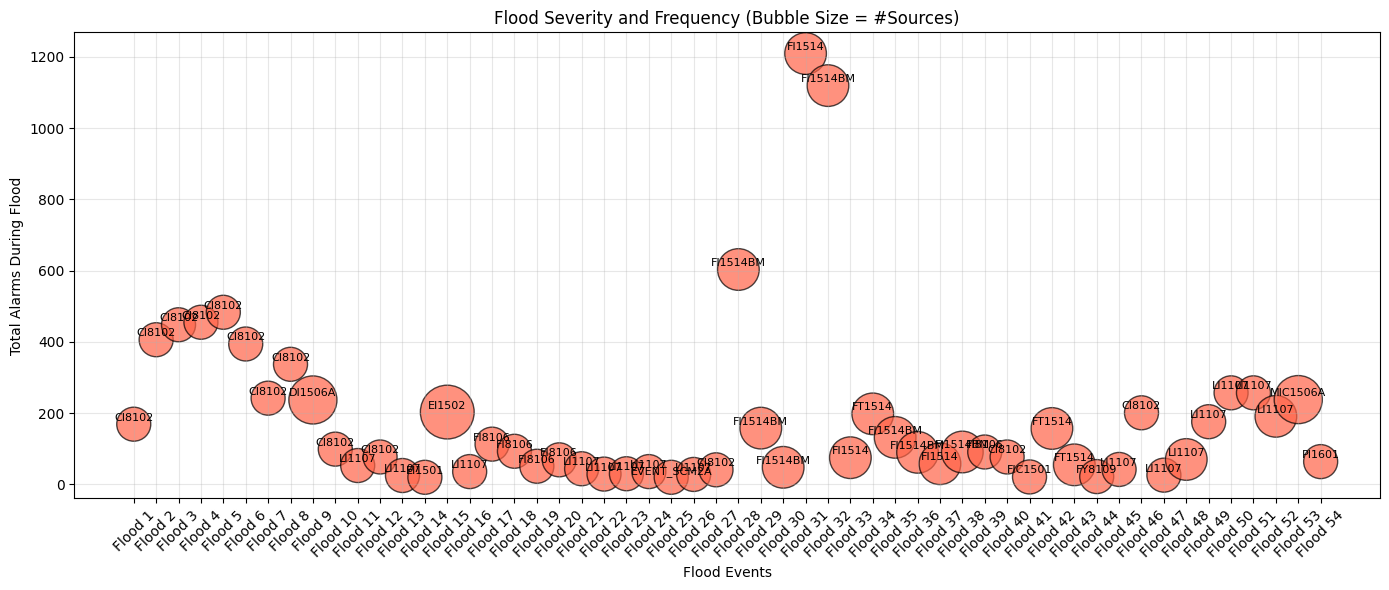

dict_keys(['x', 'y', 'size', 'hover'])


In [22]:
charts_data = prepare_flood_bubble_chart_indexed(flood_summary_df, show_plot=True)

print(charts_data.keys())
# → dict_keys(['x', 'y', 'size', 'hover'])


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_dashboard_charts(chatter_repeat_df, standing_df, flood_summary_df, bad_actors_df):
    """
    Generates dashboard KPI charts and returns structured data (x/y for frontend).
    Handles variations in column names automatically.
    """

    charts_data = {}

    # =====================================================
    # 1️⃣ Top 10 Sources by Chattering Alarms
    # =====================================================
    if "Chattering_Alarms" in chatter_repeat_df.columns:
        top_chatter = chatter_repeat_df.nlargest(10, "Chattering_Alarms")[["Source", "Chattering_Alarms"]]
        charts_data["chattering"] = {
            "x": top_chatter["Source"].tolist(),
            "y": top_chatter["Chattering_Alarms"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(top_chatter["Source"], top_chatter["Chattering_Alarms"])
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Sources by Chattering Alarms")
        plt.xlabel("Source")
        plt.ylabel("Chattering Alarms")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 2️⃣ Top 10 Sources by Repeating Alarms
    # =====================================================
    if "Repeating_Alarms" in chatter_repeat_df.columns:
        top_repeat = chatter_repeat_df.nlargest(10, "Repeating_Alarms")[["Source", "Repeating_Alarms"]]
        charts_data["repeating"] = {
            "x": top_repeat["Source"].tolist(),
            "y": top_repeat["Repeating_Alarms"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(top_repeat["Source"], top_repeat["Repeating_Alarms"], color="orange")
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Sources by Repeating Alarms")
        plt.xlabel("Source")
        plt.ylabel("Repeating Alarms")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 3️⃣ Standing vs Stale Alarms Comparison
    # =====================================================
    if {"Standing_Alarms", "Stale_Alarms"}.issubset(standing_df.columns):
        stand_stale = standing_df.nlargest(10, "Standing_Alarms")
        charts_data["standing_stale"] = {
            "x": stand_stale["Source"].tolist(),
            "y1": stand_stale["Standing_Alarms"].tolist(),
            "y2": stand_stale["Stale_Alarms"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(stand_stale["Source"], stand_stale["Standing_Alarms"],
                label="Standing", color="green", alpha=0.7)
        plt.bar(stand_stale["Source"], stand_stale["Stale_Alarms"],
                bottom=stand_stale["Standing_Alarms"],
                label="Stale", color="red", alpha=0.7)
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Standing vs Stale Alarms")
        plt.xlabel("Source")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 4️⃣ Flood Duration Distribution
    # =====================================================
    if {"Flood_Start", "Flood_End"}.issubset(flood_summary_df.columns):
        flood_summary_df["Duration_Min"] = (
            flood_summary_df["Flood_End"] - flood_summary_df["Flood_Start"]
        ).dt.total_seconds() / 60

        charts_data["flood_duration"] = {
            "x": flood_summary_df["Flood_Start"].astype(str).tolist(),
            "y": flood_summary_df["Duration_Min"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.plot(flood_summary_df["Flood_Start"], flood_summary_df["Duration_Min"],
                 marker="o", color="purple")
        plt.xticks(rotation=45, ha="right")
        plt.title("Flood Duration Trend Over Time")
        plt.xlabel("Flood Start Time")
        plt.ylabel("Duration (minutes)")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 5️⃣ Flood Size (Number of Sources Involved)
    # =====================================================
    if "Source_Count" in flood_summary_df.columns:
        charts_data["flood_size"] = {
            "x": flood_summary_df["Flood_Start"].astype(str).tolist(),
            "y": flood_summary_df["Source_Count"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(flood_summary_df["Flood_Start"].astype(str),
                flood_summary_df["Source_Count"], color="teal")
        plt.xticks(rotation=45, ha="right")
        plt.title("Number of Sources Involved per Flood")
        plt.xlabel("Flood Start Time")
        plt.ylabel("Sources Involved")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 6️⃣ Top 10 Bad Actors (Flexible Column Detection)
    # =====================================================
    if not bad_actors_df.empty:
        # detect proper column name
        col_map = [c for c in bad_actors_df.columns if "ALARM" in c.upper() or "COUNT" in c.upper()]
        if col_map:
            value_col = col_map[0]  # choose first matching column
        else:
            value_col = bad_actors_df.columns[-1]  # fallback

        top_bad = bad_actors_df.nlargest(10, value_col)
        charts_data["bad_actors"] = {
            "x": top_bad["Source"].tolist(),
            "y": top_bad[value_col].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(top_bad["Source"], top_bad[value_col], color="crimson")
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Bad Actors by Flood Alarm Count")
        plt.xlabel("Source")
        plt.ylabel(value_col.replace("_", " ").title())
        plt.tight_layout()
        plt.show()

    return charts_data


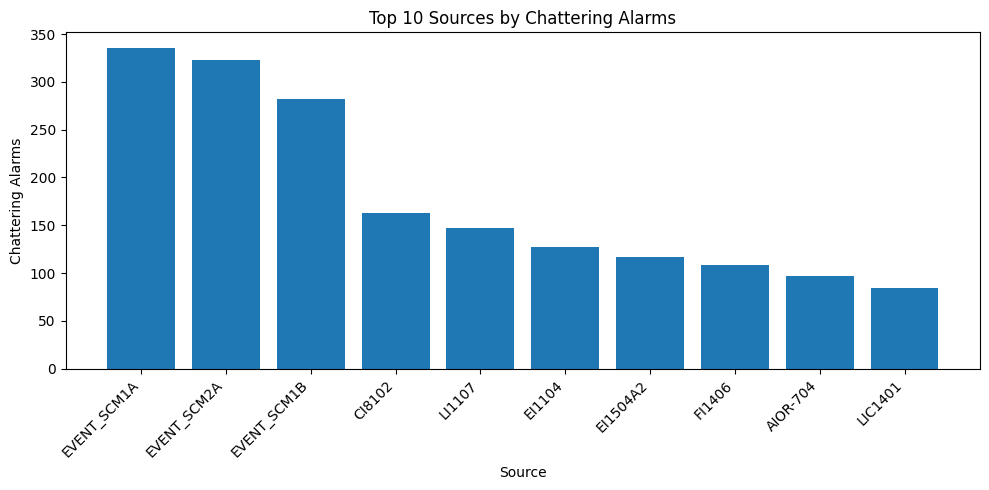

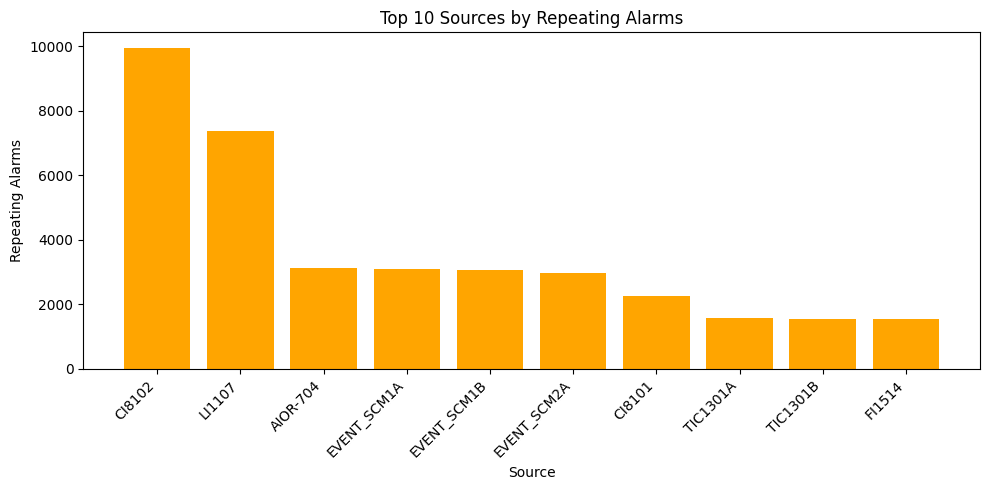

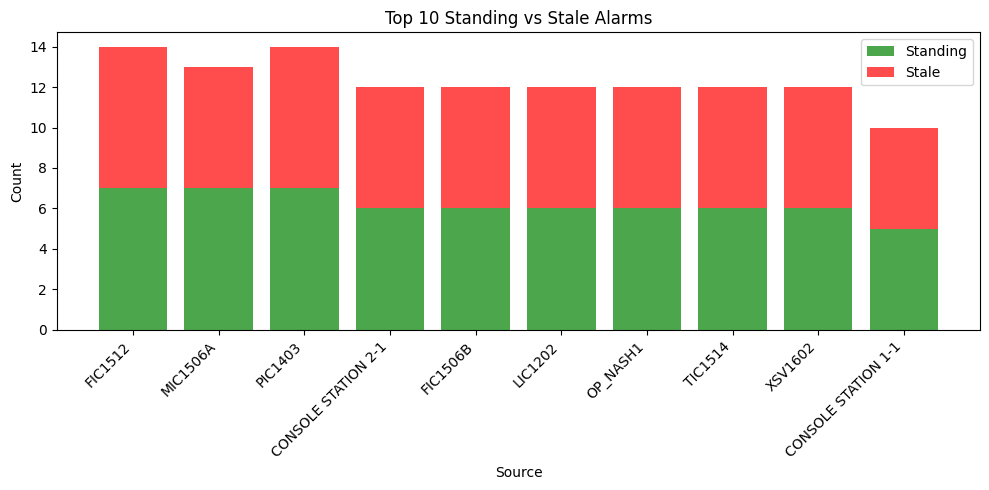

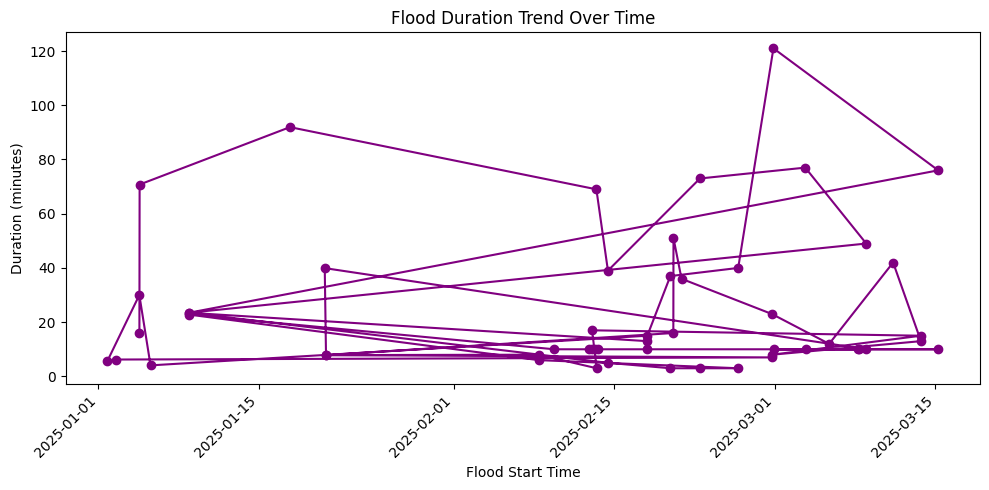

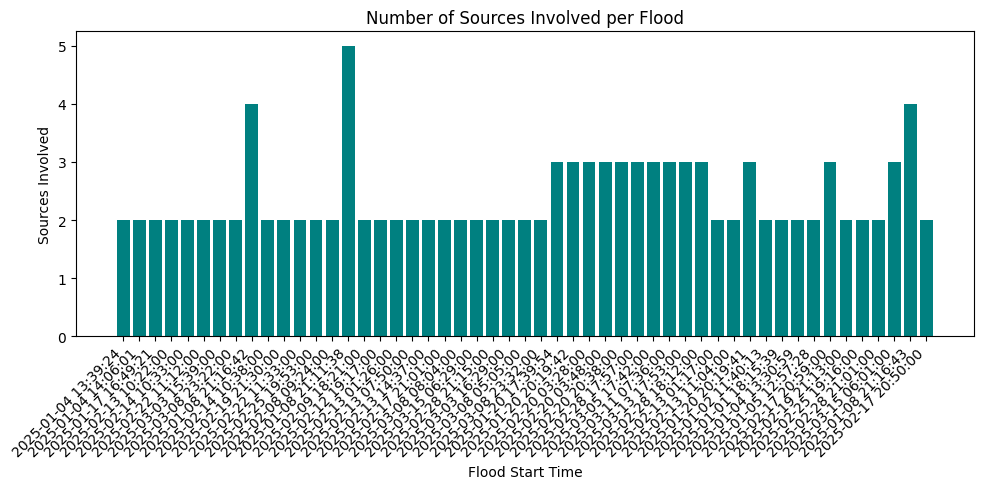

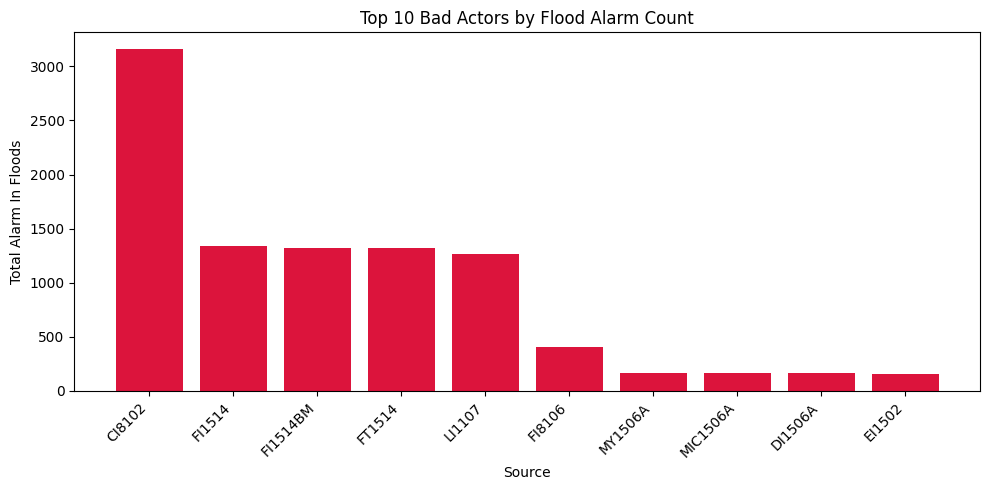

{'x': ['EVENT_SCM1A', 'EVENT_SCM2A', 'EVENT_SCM1B', 'CI8102', 'LI1107', 'EI1104', 'EI1504A2', 'FI1406', 'AIOR-704', 'LIC1401'], 'y': [335, 323, 282, 163, 147, 127, 117, 108, 97, 84]}


In [24]:
charts = generate_dashboard_charts(
    chattering_alarm_analyses,  # your chattering/repeating DataFrame
    standing_alarm_analyses,        # your standing/stale DataFrame
    flood_summary_df,   # your flood detection output
    bad_actors_df       # from identify_bad_actors()
)

# To inspect x/y data for frontend:
print(charts["chattering"])


In [25]:
# Charts for Chattering nd Stale

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_alarm_dashboard(stale_df, chattering_df):
    """
    Generate unified KPIs and chart-ready data from
    Stale/Standing and Repeating/Chattering DataFrames.
    """

    # --- 1️⃣ Merge both datasets ---
    combined = pd.merge(
        stale_df,
        chattering_df,
        on="Source",
        how="outer",
        suffixes=("_Standing", "_Chattering")
    ).fillna(0)

    # --- 2️⃣ Total KPIs ---
    total_alarms = int(combined["Unique_Alarms_Standing"].sum() + combined["Unique_Alarms_Chattering"].sum())
    total_standing = int(combined["Standing_Alarms"].sum())
    total_stale = int(combined["Stale_Alarms"].sum())
    total_repeating = int(combined["Repeating_Alarms"].sum())
    total_chattering = int(combined["Chattering_Alarms"].sum())
    total_instrument_failures = int(
        combined["Instrument_Failure"].sum() + combined["Instrument_Failures"].sum()
    )

    # --- 3️⃣ Prepare Chart Data ---

    # Pie chart: Alarm Distribution
    alarm_distribution = {
        "x": ["Standing", "Stale", "Repeating", "Chattering", "Instrument Failure"],
        "y": [total_standing, total_stale, total_repeating, total_chattering, total_instrument_failures]
    }

    # Top 10 sources by total alarms
    combined["Total_Alarms"] = (
        combined["Unique_Alarms_Standing"] + combined["Unique_Alarms_Chattering"]
    )
    top_sources = combined.nlargest(10, "Total_Alarms")[["Source", "Total_Alarms"]]
    top_sources_chart = {
        "x": top_sources["Source"].tolist(),
        "y": top_sources["Total_Alarms"].tolist()
    }

    # Stacked bar: Standing vs Chattering per top 10 sources
    top_stacked = combined.nlargest(10, "Total_Alarms")[["Source", "Standing_Alarms", "Chattering_Alarms"]]
    stacked_chart = {
        "x": top_stacked["Source"].tolist(),
        "Standing": top_stacked["Standing_Alarms"].tolist(),
        "Chattering": top_stacked["Chattering_Alarms"].tolist()
    }

    # --- 4️⃣ Summary KPIs dictionary ---
    kpi_summary = {
        "Total_Alarms": total_alarms,
        "Standing_Alarms": total_standing,
        "Stale_Alarms": total_stale,
        "Repeating_Alarms": total_repeating,
        "Chattering_Alarms": total_chattering,
        "Instrument_Failure": total_instrument_failures
    }

    # --- 5️⃣ Optional: Matplotlib Charts for validation ---
    plt.figure(figsize=(6, 6))
    plt.pie(alarm_distribution["y"], labels=alarm_distribution["x"], autopct="%1.1f%%")
    plt.title("Alarm Distribution Overview")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(top_sources_chart["x"], top_sources_chart["y"], color="skyblue")
    plt.title("Top 10 Alarm Sources")
    plt.xlabel("Source")
    plt.ylabel("Alarm Count")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(top_stacked["Source"], top_stacked["Standing_Alarms"], label="Standing")
    plt.bar(top_stacked["Source"], top_stacked["Chattering_Alarms"], bottom=top_stacked["Standing_Alarms"], label="Chattering")
    plt.title("Standing vs Chattering (Top 10 Sources)")
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # --- 6️⃣ Return everything for frontend ---
    return {
        "alarm_distribution": alarm_distribution,
        "top_sources": top_sources_chart,
        "stacked_chart": stacked_chart,
        "kpi_summary": kpi_summary
    }


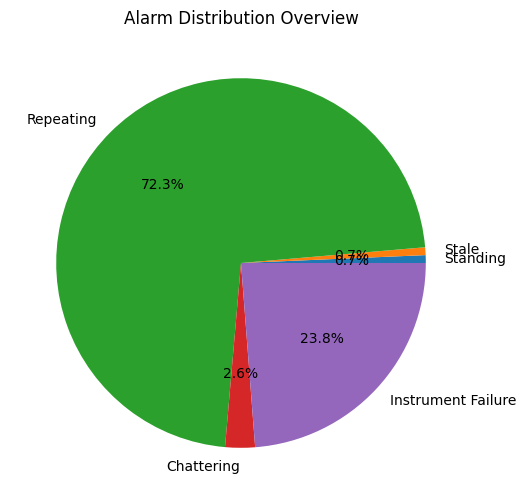

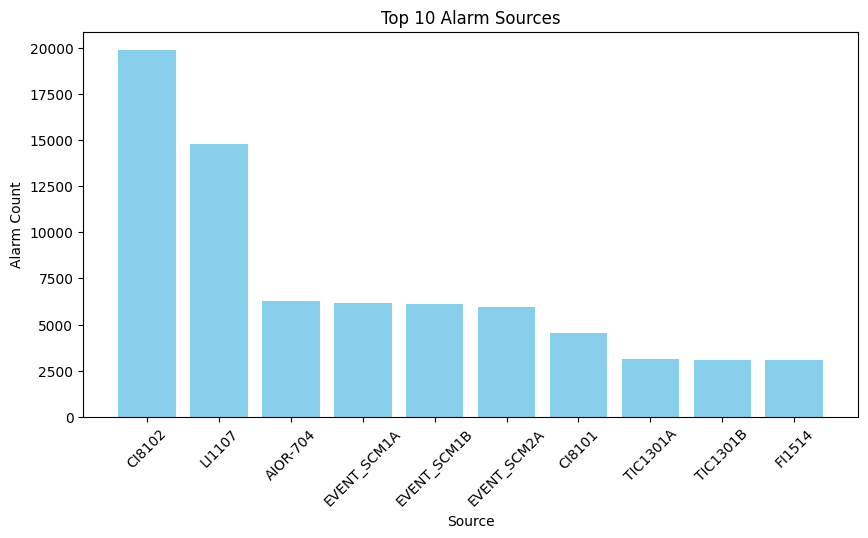

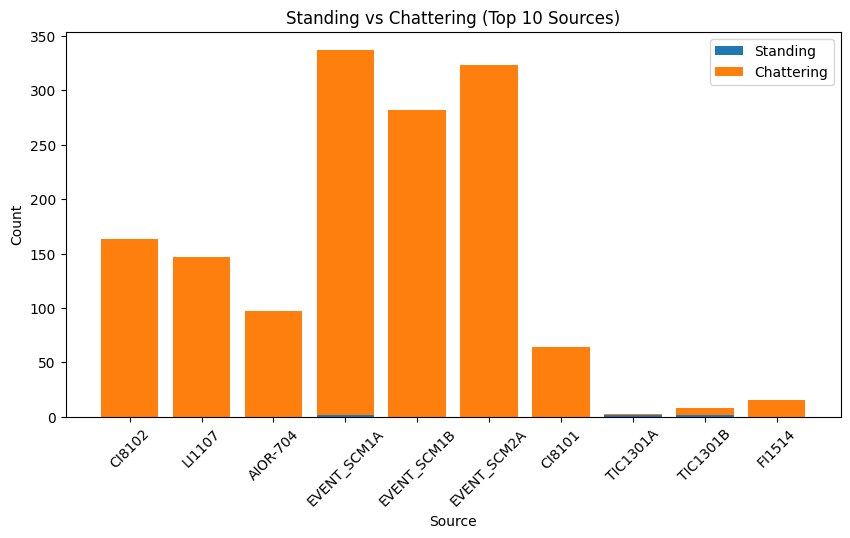

{'alarm_distribution': {'x': ['Standing',
   'Stale',
   'Repeating',
   'Chattering',
   'Instrument Failure'],
  'y': [904, 903, 96102, 3456, 31623]},
 'top_sources': {'x': ['CI8102',
   'LI1107',
   'AIOR-704',
   'EVENT_SCM1A',
   'EVENT_SCM1B',
   'EVENT_SCM2A',
   'CI8101',
   'TIC1301A',
   'TIC1301B',
   'FI1514'],
  'y': [19866, 14770, 6280, 6162, 6126, 5970, 4524, 3124, 3102, 3082]},
 'stacked_chart': {'x': ['CI8102',
   'LI1107',
   'AIOR-704',
   'EVENT_SCM1A',
   'EVENT_SCM1B',
   'EVENT_SCM2A',
   'CI8101',
   'TIC1301A',
   'TIC1301B',
   'FI1514'],
  'Standing': [0, 0, 0, 2, 0, 0, 0, 2, 2, 0],
  'Chattering': [163, 147, 97, 335, 282, 323, 64, 1, 6, 15]},
 'kpi_summary': {'Total_Alarms': 194658,
  'Standing_Alarms': 904,
  'Stale_Alarms': 903,
  'Repeating_Alarms': 96102,
  'Chattering_Alarms': 3456,
  'Instrument_Failure': 31623}}

In [27]:
generate_alarm_dashboard(standing_alarm_analyses, chattering_alarm_analyses)